# Рынок заведений общественного питания Москвы

Перед нами стоит задача изучить рынок общественного питания Москвы и предложить формат нового заведения.

**План:**
1. [Предобработать данные:](#preprocessing)
   - найти пропуски,
   - найти дубликаты,
   - привести данные к нужному типу.
2. [Проанализировать данные:](#analyzing)
   - создать столбцы с недостающими данными,
   - построить графики.
3. [Подготовить презентацию.](#presentation)

<a id='preprocessing'></a>

## Предобработаем данные

In [2]:
# импортируем библиотеки, необходимые для работы
import pandas as pd # для работы с данными
import numpy as np # для работы с числами
import seaborn as sns # для визуализации
import matplotlib.pyplot as plt # для настройки визуализации
import re # для регулярных выражений
from io import StringIO 
import requests
%matplotlib inline
%config InlineBackend.figure_format='retina' # повышение четкости графиков
plt.style.use('seaborn-darkgrid') # задаём стиль графиков

In [3]:
df = pd.read_csv('/datasets/rest_data.csv')

Посмотрим на основную информацию о данных.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Также сразу посмотрим на наличие полных дубликатов.

In [5]:
df.duplicated().sum()

0

Явных пропусков нет, дубликатов тоже, типы данных в порядке. Посмотрим на первые 5 строк.

In [6]:
df.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Посмотрим, какие значения принимают столбцы с данными о сети и типе заведения и нет ли скрытых дубликатов.

In [7]:
df['chain'].unique()

array(['нет', 'да'], dtype=object)

In [8]:
df['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Никаких явных проблем в данных нет.

Чтобы данные о типе заведения лучше смотрелись на графике, сделаем первую букву типа заведения строчной.

In [9]:
df['object_type'] = df['object_type'].str.capitalize()

Для ускорения и упрощения обработки данных приведём столбец с данными о сети к булевому типу.

In [10]:
df['chain'] = df['chain']=='да'

<a id='analyzing'></a>

## Анализируем данные

Построим столбчатую диаграмму количества заведений каждого типа.

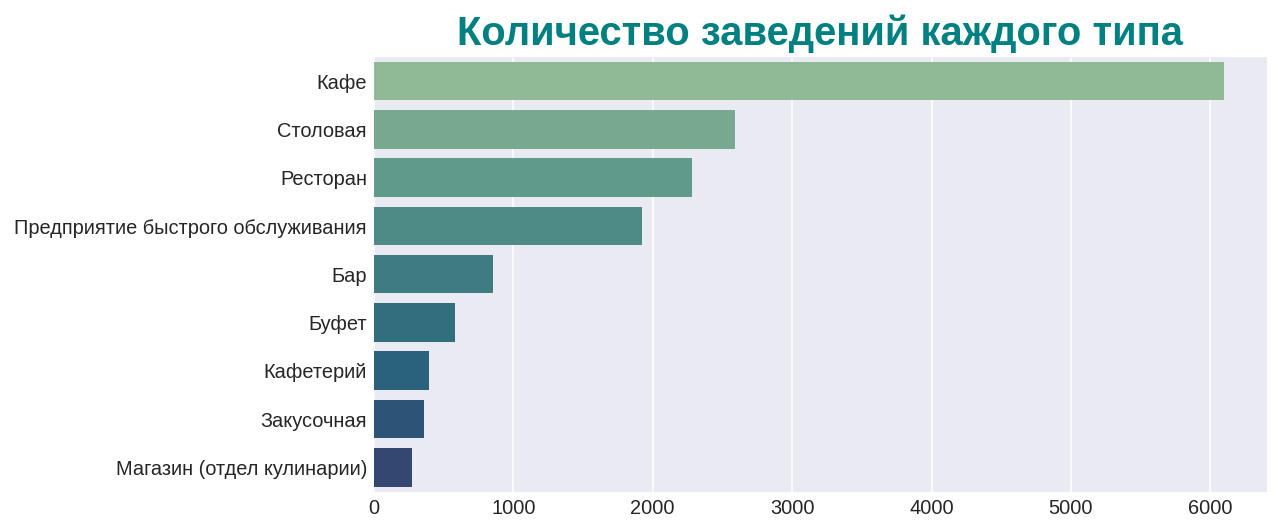

In [11]:
plt.figure(figsize=(8,4))
plt.title('Количество заведений каждого типа', fontsize=20, fontweight='bold', color='teal')
sns.barplot(
    x='object_type',
    y='index',
    data=df['object_type'].value_counts().reset_index(),
    palette='crest',
    orient='h'
)
plt.xlabel(None)
plt.ylabel(None);

Довольно ожидаемо на первом месте кафе. Дальше, что неожиданно, идут столовые. Посмотрим на них поближе.

In [12]:
df.query('object_type=="Столовая"').head()

,id,object_name,chain,object_type,address,number
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,False,Столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240
7,20957,Буфет МТУСИ,False,Столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90
8,20958,КПФ СЕМЬЯ-1,False,Столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150
9,28858,Столовая МТУСИ,False,Столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120
12,28582,ШКОЛА 735,False,Столовая,"город Москва, Авиамоторная улица, дом 51",140


Оказывается в нашем датасете записаны даже столовые при учебных заведениях, поэтому их оказалось так много.

Теперь посмотрим, сколько заведений являются сетевыми.

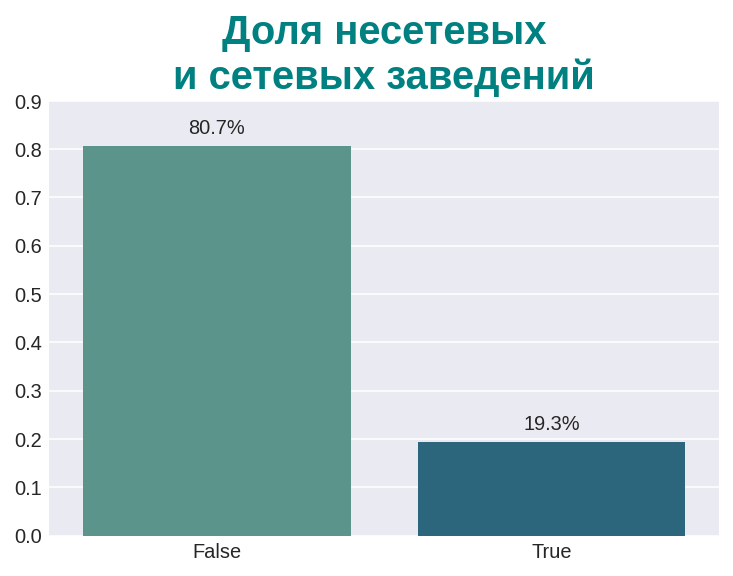

In [13]:
plt.figure(figsize=(6,4))
plt.title('Доля несетевых\nи сетевых заведений', fontsize=20, fontweight='bold', color='teal')
ax = sns.barplot(
    x='index',
    y='chain',
    data=df['chain'].value_counts(normalize=True).reset_index(),
    palette='crest'
)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1%'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.xlabel(None)
plt.ylabel(None)
plt.ylim(0,.9);

Из графика видно, что несетевых заведений примерно в 4 раза больше. Посмотрим, какого типа в основном сетевые заведения.

In [14]:
chain_or_not = (
    df
    .groupby(['object_type', 'chain'])
    .agg({'id': 'count'})
    .sort_values(['chain', 'id'], ascending=False)
    .reset_index()
)

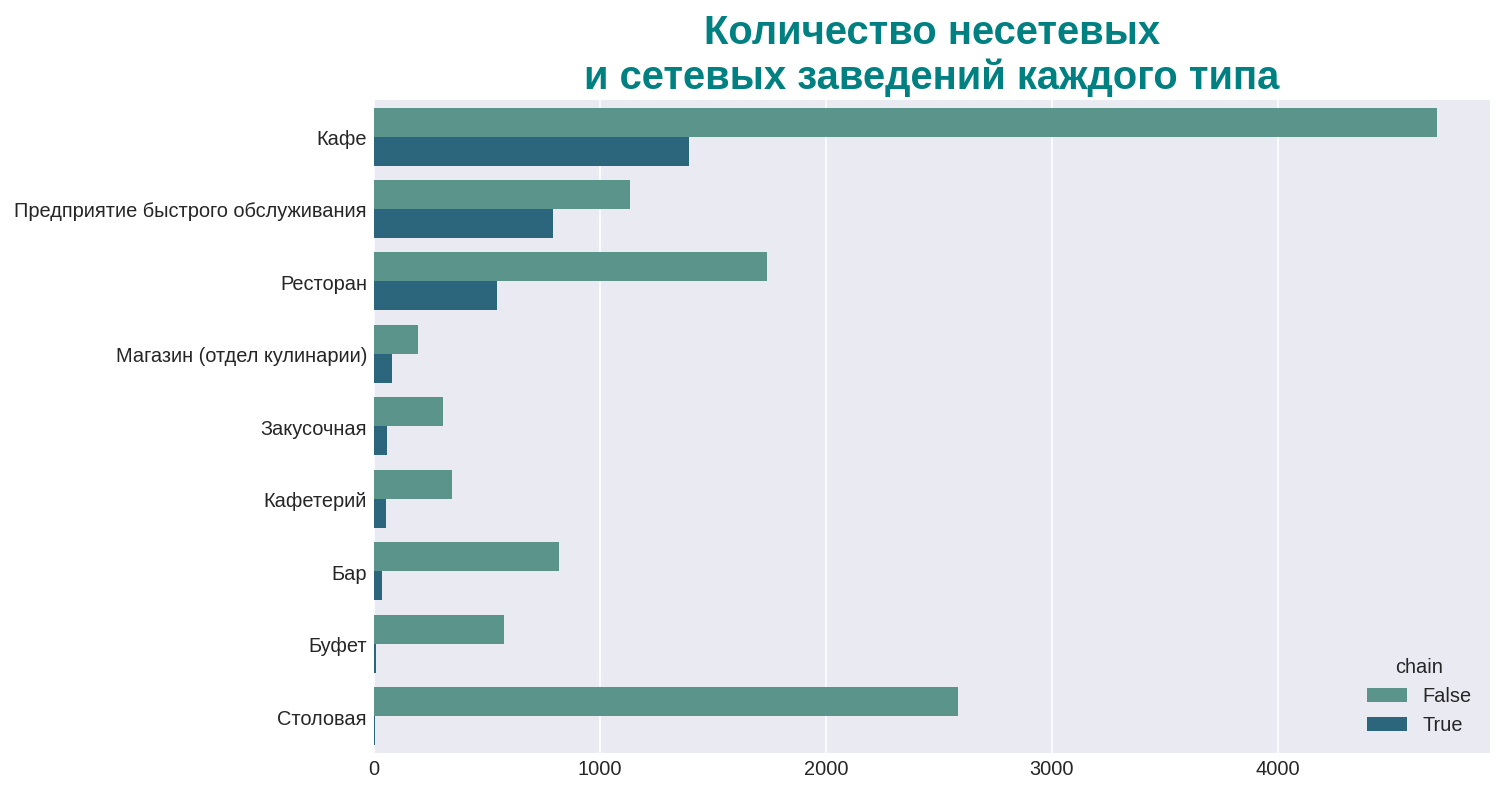

In [15]:
plt.figure(figsize=(10,6))
plt.title('Количество несетевых\nи сетевых заведений каждого типа', fontsize=20, fontweight='bold', color='teal')
sns.barplot(
    x='id',
    y='object_type',
    hue='chain',
    data=chain_or_not,
    palette='crest',
    orient='h'
)
plt.xlabel(None)
plt.ylabel(None);

По числу сетевых заведений столовые опустились на последнее место (и фактически исчезли из рейтинга). На первом месте по-прежнему кафе: хотя только примерно каждое четвертое — сетевое.  
А вот на второе место вышли **фаст-фуды: почти половина их — сетевые.** Неудивительно, ведь они берут именно количеством.  
На третьем месте рестораны, остальные заведения — **в основном только несетевые.**

Чтобы построить график распределения среднего количества посадочных мест и количества заведений сети, нужно сгруппировать данные по сетям. Перед этим нужно убедиться, что названия заведений написаны одинаково.

In [16]:
df[df['chain']]['object_name'].value_counts()

KFC                                                    155
Шоколадница                                            141
Макдоналдс                                             122
Бургер Кинг                                            122
Домино'с Пицца                                          86
                                                      ... 
Закусочная «KFC»                                         1
Предприятие быстрого обслуживания «Крошка Картошка»      1
Городские автокофейни                                    1
Николай                                                  1
Дабл би                                                  1
Name: object_name, Length: 724, dtype: int64

Приведём данные к более общему виду: сделаем все буквы прописными, уберем кавычки и слова «кафе», «ресторан» и «кофейня» из названий заведений.

In [17]:
df['object_name'] = (
    df['object_name']
    .str.lower()
    .str.replace('кафе ', '')
    .str.replace('ресторан ', '')
    .str.replace('ресторан', '')
    .str.replace('кофейня ', '')
    .str.replace('«', '')
    .str.replace('»', '')
)

In [18]:
df[df['chain']]['object_name'].value_counts()

шоколадница           183
kfc                   170
макдоналдс            166
бургер кинг           144
теремок               105
                     ... 
grand урюк              1
брава коста кофе        1
пбо kfc покрышкина      1
сити                    1
мята                    1
Name: object_name, Length: 462, dtype: int64

Список сократился на 260 позиций, отличный результат. Видно, что остались нетипичные названия вроде «Москва — Макдоналдс», но ручной перебор таких ошибок требует слишком больших ресурсов, так что остановимся на том, что уже есть.  
  
Создадим таблицу с количеством заведений сети и средним количеством посадочных мест.

In [19]:
chains = df[df['chain']].groupby('object_name', as_index=False).agg({'id': 'count', 'number': 'mean'})

Построим график рассеяния и нанесем на него линию, обозначающую 100 посадочных мест, чтобы посмотреть, какие заведения преобладают.

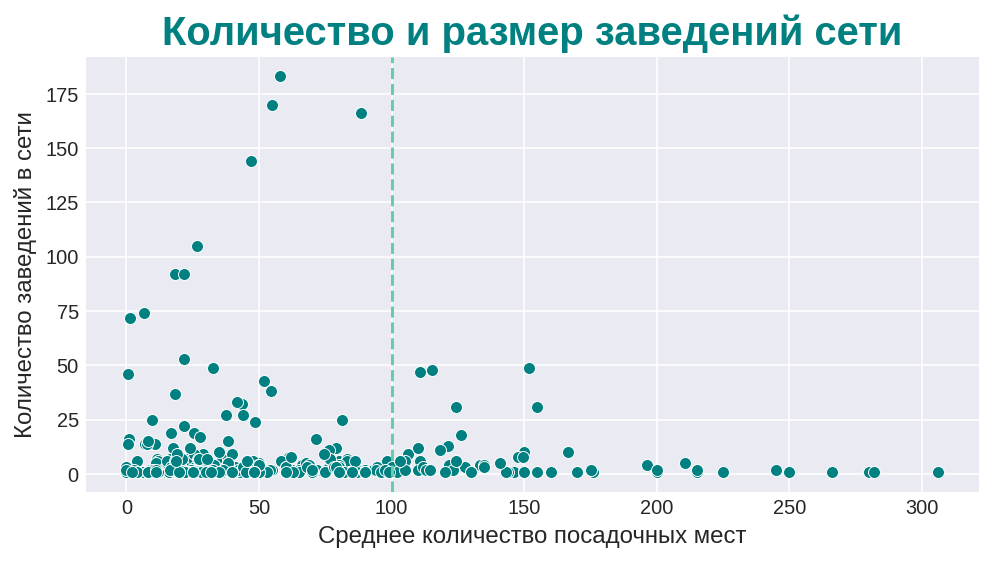

In [20]:
plt.figure(figsize=(8,4))
plt.title('Количество и размер заведений сети', fontsize=20, fontweight='bold', color='teal')
sns.scatterplot(
    x='number',
    y='id',
    data=chains,
    color='teal')
plt.xlabel('Среднее количество посадочных мест', fontsize=12)
plt.ylabel('Количество заведений в сети', fontsize=12)
plt.axvline(x=100, color='mediumaquamarine', linestyle='--');

Из графика видно, что на рынке преобладают сети с большим количеством заведений и небольшим количеством посадочных мест.

Теперь посмотрим на количество мест в заведениях разного типа.

In [21]:
seats = (
    df
    .groupby('object_type', as_index=False)
    .agg({'number': 'mean'})
    .sort_values('number', ascending=False)
)

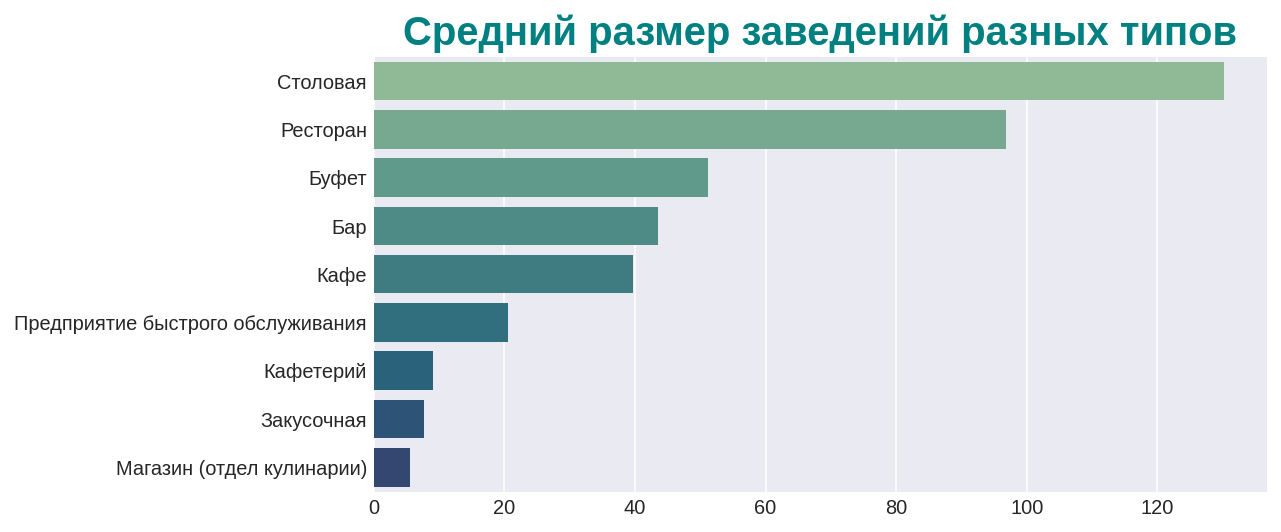

In [22]:
plt.figure(figsize=(8,4))
plt.title('Средний размер заведений разных типов', fontsize=20, fontweight='bold', color='teal')
sns.barplot(
    x='number',
    y='object_type',
    data=seats,
    palette='crest',
    orient='h'
)
plt.xlabel(None)
plt.ylabel(None);

На первом месте столовые — там много посадочных мест, потому что студенты и школьники приходят туда на обед, и места должно хватить всем. Затем идут рестораны, что логично — они как правило больше остальных заведений. Далее с небольшой разницей — бары, кафе и фаст-фуды, заведения среднего размера. На последних 4 местах — заведения небольшого формата: закусочные, буфеты, кафетерии и кулинарные отделы супермаркетов.

Чтобы выделить улицу из адреса, запишем адрес только прописными буквами, а затем применим регулярное выражение.

In [23]:
df['address'] = df['address'].str.lower()

In [24]:
words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия',
         'квартал', 'микрорайон', 'парк', 'просека']

str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))

df["street"] = df["address"].str.extract(str_pat, flags=re.I)

Посмотрим, все ли строки обработаны корректно.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 7 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null bool
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
street         14991 non-null object
dtypes: bool(1), int64(2), object(4)
memory usage: 735.4+ KB


Чуть меньше 400 строк оказались с пропусками в данных об улице. Это в основном адреса без улицы (например, «деревня Пушкино, дом 5»). Теперь по улице присоединим к таблице данные о районе и округе Москвы. Для этого загрузим таблицу соответствия улицы району.

In [26]:
spreadsheet_id = '13Upvg__ELbqc1-Wk__PP4AsqTf2GWt2MzCybuRBRJdg'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
response = requests.get(file_name)
response = response.content.decode('utf-8')
streets = pd.read_csv(StringIO(response))

Чтобы данные совпали с нашей таблицей, сделаем все буквы прописными.

In [27]:
streets['street'] = streets['street'].str.lower()

In [28]:
areas_count = df.merge(streets, how='left', on='street')

Удалим дубликаты в названиях улиц.

In [29]:
streets = streets.drop_duplicates(subset='street')

Присоединим данные о районах и округах к нашей таблице.

In [30]:
df = df.merge(streets, how='left', on='street')

In [31]:
df.tail()

,id,object_name,chain,object_type,address,number,street,okrug,area
15361,208537,шоколадница,True,Кафе,"город москва, 3-й крутицкий переулок, дом 18",50,3-й крутицкий переулок,ЦАО,Таганский район
15362,209264,шоколадница,True,Кафе,"город москва, улица земляной вал, дом 33",10,улица земляной вал,ЦАО,Таганский район
15363,209186,шоколадница,True,Кафе,"город москва, улица земляной вал, дом 33",20,улица земляной вал,ЦАО,Таганский район
15364,221900,шоколадница,True,Кафе,"город москва, поселение московский, киевское ш...",36,киевское шоссе,ЗАО,Район Внуково
15365,222535,шоколадница,True,Кафе,"город москва, ходынский бульвар, дом 4",10,ходынский бульвар,САО,Хорошевский район


Создадим таблицу с 10 улицами с самым большим числом заведений. Построим график и посмотрим, что это за улицы.

In [32]:
top_streets = (
    areas_count
    .groupby(['street', 'area', 'okrug'])
    .agg({'id': 'count'})
    .sort_values('id', ascending=False)
    .reset_index()
)
top_areas = top_streets.groupby('street', sort=False)['area'].apply(list).reset_index().head(11)
top_streets = top_streets[['street', 'okrug']].drop_duplicates()
top_okrug = top_streets.groupby('street', sort=False)['okrug'].apply(list).reset_index().head(11)

In [33]:
top10_streets = df['street'].value_counts().head(10).reset_index()
top10_streets.columns = ['street', 'count']

In [34]:
top10_streets = top10_streets.merge(top_areas, on='street', how='left').merge(top_okrug, on='street', how='left')

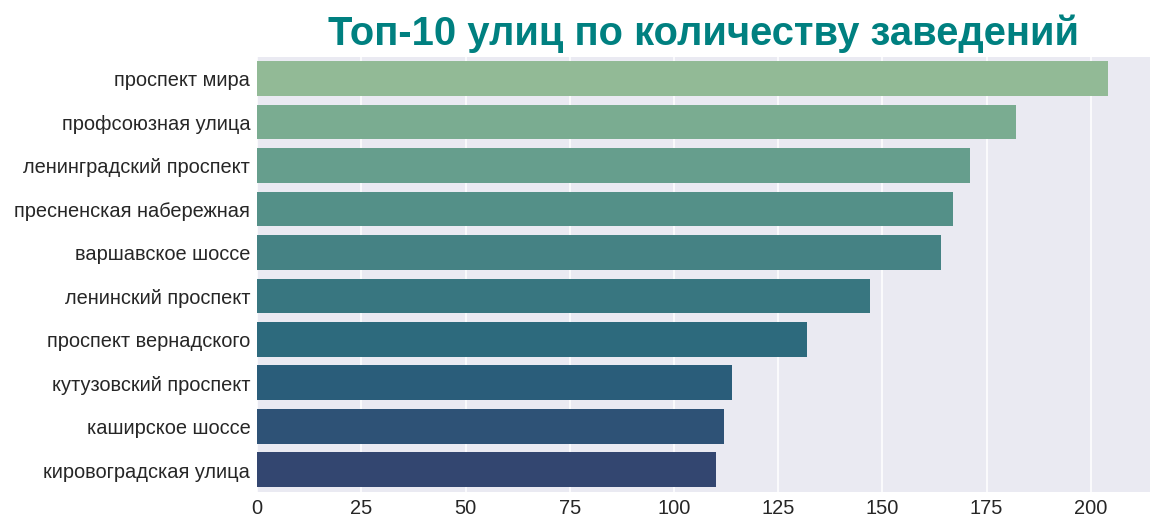

In [35]:
plt.figure(figsize=(8,4))
plt.title('Топ-10 улиц по количеству заведений', fontsize=20, fontweight='bold', color='teal')
sns.barplot(
    x='count',
    y='street',
    data=top10_streets,
    palette='crest',
    orient='h'
)
plt.xlabel(None)
plt.ylabel(None);

Большинство из улиц на графике — огромные проспекты и шоссе, проходящие через половину города, настоящие городские артерии. Неудивительно, что именно на них расположено больше всего заведений. Посмотрим, в каких районах и округах Москвы находятся эти улицы.

In [36]:
top10_streets

,street,count,area,okrug
0,проспект мира,204,"[Район Свиблово, Ярославский Район, Алексеевск...","[СВАО, ЦАО]"
1,профсоюзная улица,182,"[Район Теплый Стан, Район Ясенево, Академическ...",[ЮЗАО]
2,ленинградский проспект,171,"[Район Сокол, Хорошевский район, Район Беговой...",[САО]
3,пресненская набережная,167,[Пресненский район],[ЦАО]
4,варшавское шоссе,164,"[Район Южное Бутово, Район Северное Бутово, Ра...","[ЮЗАО, ЮАО]"
5,ленинский проспект,147,"[Ломоносовский район, Обручевский район, Район...","[ЮЗАО, ЗАО, ЦАО, ЮАО]"
6,проспект вернадского,132,"[Район Тропарево-Никулино, Район Раменки, Райо...","[ЗАО, ЮЗАО]"
7,кутузовский проспект,114,"[Район Фили-Давыдково, Район Дорогомилово]",[ЗАО]
8,каширское шоссе,112,"[Район Орехово-Борисово Северное, Район Орехов...",[ЮАО]
9,кировоградская улица,110,"[Район Чертаново Центральное, Район Чертаново ...",[ЮАО]


Все улицы расположены в разных районах и округах. Количество заведений связано с тем, что эти улицы очень длинные.  
  
Исключение — Пресненская набережная, расположенная в центре Москвы. На ней расположен комплекс Москва-сити, внутри которого много заведений для работников комплекса.

Посмотрим на улицы с всего одним заведением. Найдём, в каких районах они находятся.

In [37]:
bottom_streets = areas_count.drop_duplicates(subset='street', keep=False)

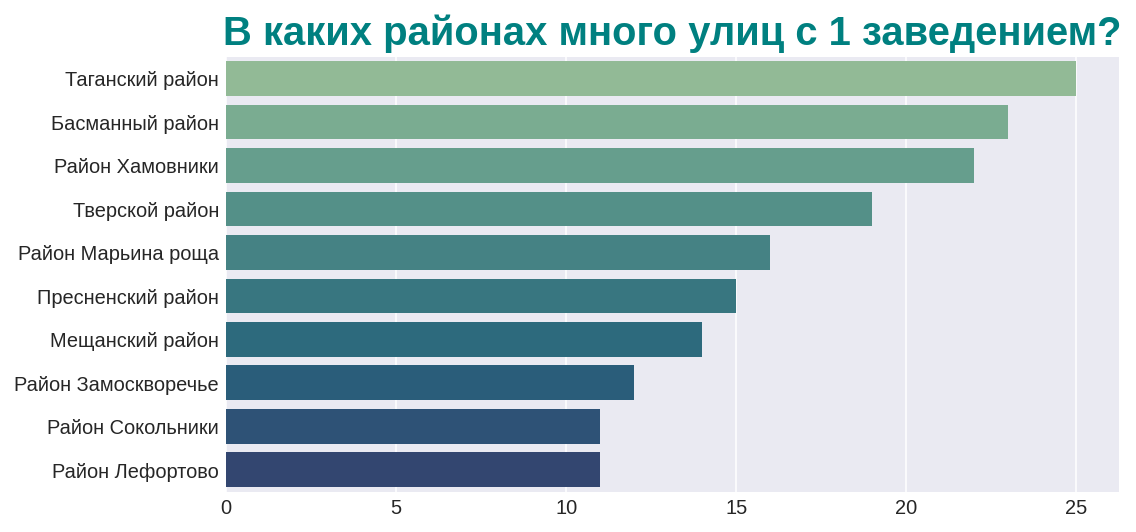

In [38]:
plt.figure(figsize=(8,4))
plt.title('В каких районах много улиц с 1 заведением?', fontsize=20, fontweight='bold', color='teal')
sns.barplot(
    x='area',
    y='index',
    data=bottom_streets['area'].value_counts().reset_index().head(10),
    palette='crest',
    orient='h'
)
plt.xlabel(None)
plt.ylabel(None);

Большинство улиц с одним заведением находятся в центральных и самых престижных районах Москвы. Скорее всего это связано с тем, что в центре много очень маленьких улиц и переулков, поэтому даже если заведений там много, формально находятся они на разных улицах.

Посмотрим, сколько посадочных мест на улицах с самым большим числом заведений.

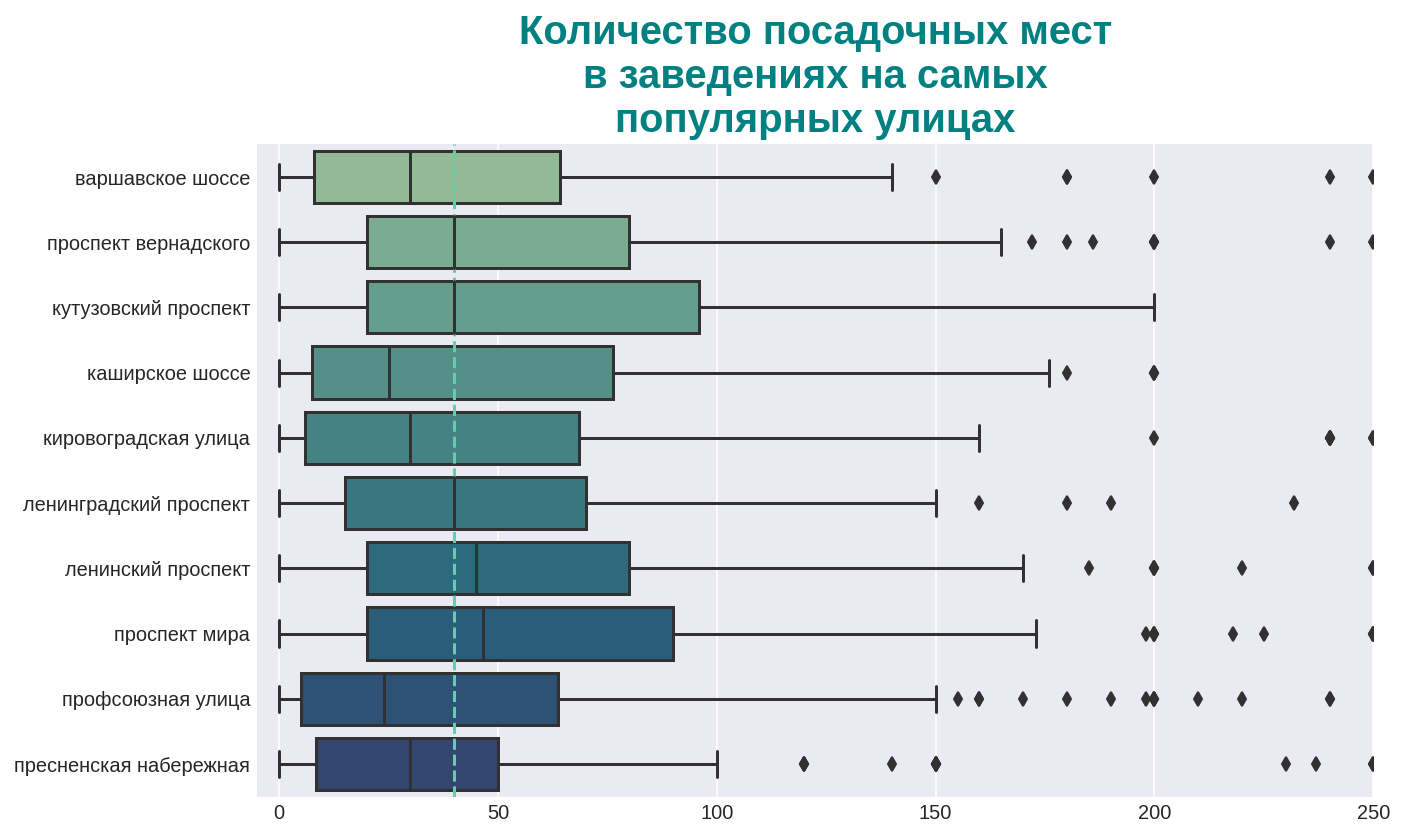

In [39]:
top10_streets_list = top10_streets['street']
plt.figure(figsize=(10,6))
plt.title(
    'Количество посадочных мест\nв заведениях на самых\nпопулярных улицах',
    fontsize=20,
    fontweight='bold',
    color='teal')
sns.boxplot(
    x='number',
    y='street',
    data=df.query('street in @top10_streets_list'),
    orient='h',
    palette='crest')
plt.xlim(-5,250)
plt.axvline(
    df.query('street in @top10_streets_list')['number'].median(),
    color='mediumaquamarine',
    linestyle='--')
plt.xlabel(None)
plt.ylabel(None);

Медианное количество мест на всех улицах находится в районе 30-50, при этом подавляющее число заведений имеют меньше 100 посадочных мест (3-й квартиль у всех ниже 100).

## Вывод

Учитывая, что закупка роботов обойдётся дорого, лучше открыть заведение с большим количеством мест, чтобы быстрее окупить затраты. К тому же, так мы сократим и затраты на одного клиента. Также нет смысла открывать фаст-фуд, столовую или другое заведение с самообслуживанием. Лучше всего подойдут **ресторан** или **большое кафе, например, детское.**  
  
Оптимальное количество мест — **100.** Это среднее количество мест для ресторана.  
  
Лучше расположить заведение **в центре города.** Это не будет заведение формата «поесть недалеко от дома», люди будут съезжаться со всех уголков Москвы, и лучше, чтобы всем было удобно.

Основная идея заведения в официантах-роботах, для 2021 года это необычный формат, и лучше, чтобы оно оставалось уникальным. Если создать сеть, может пропасть ощущение диковинки, и люди вовсе перестанут в него ходить. К тому же, большинство кафе и ресторанов как раз несетевые.

<a href='https://drive.google.com/file/d/1KEp_pamhsyBizHoExfXT6y1_J9DwXLUo/view?usp=sharing'>Cсылка на презентацию</a> <a id='presentation'></a>